# ⛩ push to github

In [74]:
#%%capture
import os
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive',
            force_remount=True
            )


notebookname = 'SEO.ipynb'

class github:
    def __init__(self, github_pat, github_email, github_username, github_repo, gdrive_notebook_folder, notebook_name):
        self.github_pat = userdata.get(github_pat)
        self.github_email = userdata.get(github_email)
        self.github_username = userdata.get(github_username)
        self.github_repo = userdata.get(github_repo)
        self.gdrive_notebook_folder = userdata.get(gdrive_notebook_folder)
        self.notebook_name = notebook_name

    def clone_repo(self):
        # Source file path in Google Drive
        source_file_path = f"/content/drive/MyDrive/{self.gdrive_notebook_folder}/{self.notebook_name}"

        # Repository details
        repo_url = f'https://{self.github_pat}@github.com/{self.github_username}/{self.github_repo}.git'

        # Clone the private repository
        !git clone {repo_url} cloned-repo
        os.chdir('cloned-repo')  # Switch to the cloned repository

        # Ensure the file exists in Google Drive
        if os.path.exists(source_file_path):
            # Copy the notebook into the cloned repository
            !cp "{source_file_path}" ./
        else:
            print(f"The file {source_file_path} was not found.")
            return  # Exit if the file doesn't exist

        # Git configuration
        !git config user.email "{self.github_email}"
        !git config user.name "{self.github_username}"

        # Add the file to Git
        !git add "{self.notebook_name}"

        # Commit the changes
        !git commit -m "Added {self.notebook_name} from Google Drive"

        # Push to the repository
        !git push origin main

        # Wechsle zurück ins übergeordnete Verzeichnis und lösche cloned-repo
        os.chdir('..')
        !rm -rf cloned-repo
        print("cloned-repo wurde wieder gelöscht.")



# Clone, add, and push the notebook
clone_2 = github('github_pat', 'github_email', 'github_username', 'github_repo_seo', 'gdrive_seo_folder', notebookname)
clone_2.clone_repo()


Mounted at /content/drive
Cloning into 'cloned-repo'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 105 (delta 30), reused 94 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (105/105), 789.02 KiB | 6.07 MiB/s, done.
Resolving deltas: 100% (30/30), done.
[main 105e9ee] Added SEO.ipynb from Google Drive
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite SEO.ipynb (90%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 11.88 KiB | 553.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/MarkH0705/SEO_Analyses.git
   841de6e..105e9ee  main -> main
cloned-repo wurde wieder gelöscht.


# 🕸 scrap

In [39]:
import os
import requests
from bs4 import BeautifulSoup, Comment
from urllib.parse import urljoin, urlparse
import chardet


class WebsiteScraper:
    """
    Diese Klasse kümmert sich ausschließlich um das Sammeln und Extrahieren
    von Texten aus einer Website.
    """

    def __init__(self, start_url="https://www.rue-zahnspange.de", max_pages=50):
        """
        :param start_url: Die Start-URL der Website, z.B. "https://www.example.com"
        :param max_pages: Maximale Anzahl Seiten, die gecrawlt werden.
        """
        self.start_url = start_url
        self.max_pages = max_pages

        # Hier speichern wir {URL: reiner_Text}
        self.scraped_data = {}

    def scrape_website(self):
        """
        Startet den Crawl-Vorgang, gefolgt von der Extraktion des Textes
        und dem Sammeln interner Links.
        """
        visited = set()
        to_visit = [self.start_url]
        domain = urlparse(self.start_url).netloc

        while to_visit and len(visited) < self.max_pages:
            url = to_visit.pop(0)
            if url in visited:
                continue
            visited.add(url)

            try:
                response = requests.get(url, timeout=10)

                # Rohdaten holen und Encoding per chardet bestimmen
                raw_data = response.content
                detected = chardet.detect(raw_data)
                encoding = "utf-8"
                text_data = raw_data.decode(encoding, errors="replace")

                # Nur weiterverarbeiten, wenn HTML-Content
                if (response.status_code == 200
                        and "text/html" in response.headers.get("Content-Type", "")):
                    soup = BeautifulSoup(text_data, "html.parser")

                    # Text extrahieren
                    text = self._extract_text_from_soup(soup)
                    self.scraped_data[url] = text

                    # Interne Links sammeln
                    for link in soup.find_all("a", href=True):
                        absolute_link = urljoin(url, link["href"])
                        if urlparse(absolute_link).netloc == domain:
                            if (absolute_link not in visited
                                    and absolute_link not in to_visit):
                                to_visit.append(absolute_link)

            except requests.RequestException as e:
                print(f"Fehler beim Abrufen von {url}:\n{e}")

    def _extract_text_from_soup(self, soup):
        """
        Extrahiert aus <p>, <h1>, <h2>, <h3>, <li> reinen Text,
        entfernt Script-/Style-/Noscript-Tags und Kommentare.
        """
        for script_or_style in soup(["script", "style", "noscript"]):
            script_or_style.decompose()

        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()

        texts = []
        for tag in soup.find_all(["p", "h1", "h2", "h3", "li", "faq4_question", "faq4_answer"]):
            txt = tag.get_text(strip=True)
            if txt:
                texts.append(txt)

        return "\n".join(texts)




    def _extract_text_from_soup(self, soup):
        """
        Extrahiert aus <p>, <h1>, <h2>, <h3>, <li> reinen Text,
        aber NICHT die, die in .faq4_question oder .faq4_answer stecken.
        Außerdem extrahiert er separat die FAQ-Fragen und -Antworten
        (faq4_question / faq4_answer).
        """
        # 1) Script/Style entfernen
        for script_or_style in soup(["script", "style", "noscript"]):
            script_or_style.decompose()

        # 2) Kommentare entfernen
        from bs4 import Comment
        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()

        # 3) Normale Texte (p, h1, h2, h3, li), ABER nicht innerhalb von .faq4_question / .faq4_answer
        texts = []
        all_normal_tags = soup.find_all(["p", "h1", "h2", "h3", "li"])
        for tag in all_normal_tags:
            # Prüfen, ob das Tag einen Vorfahren (Parent) hat mit Klasse faq4_question oder faq4_answer
            # Wenn ja, ignorieren wir es
            if tag.find_parent(class_="faq4_question") or tag.find_parent(class_="faq4_answer"):
                continue

            txt = tag.get_text(strip=True)
            if txt:
                texts.append(txt)

        # 4) FAQ-Bereiche (Fragen + Antworten)
        #    a) Alle Frage-Elemente mit Klasse .faq4_question
        #    b) Alle Antwort-Elemente mit Klasse .faq4_answer
        #    Wir gehen davon aus, dass Frage i zum Antwort i passt.

        questions = soup.select(".faq4_question")
        answers = soup.select(".faq4_answer")

        # 5) Zusammenführen (Frage + Antwort)
        for q, a in zip(questions, answers):
            q_text = q.get_text(strip=True)
            a_text = a.get_text(strip=True)
            if q_text and a_text:
                combined = f"Frage: {q_text}\nAntwort: {a_text}"
                texts.append(combined)

        # 6) Als String zurückgeben
        return "\n".join(texts)





    def get_scraped_data(self):
        """
        Gibt das Dictionary {URL: Text} zurück.
        Du kannst damit arbeiten, Seiten filtern, etc.
        """
        return self.scraped_data


# 📊SEO Analysis

In [40]:
pip install git+https://github.com/sethblack/python-seo-analyzer.git

  Cloning https://github.com/sethblack/python-seo-analyzer.git to /tmp/pip-req-build-h2ap7kl7
  Running command git clone --filter=blob:none --quiet https://github.com/sethblack/python-seo-analyzer.git /tmp/pip-req-build-h2ap7kl7
  Resolved https://github.com/sethblack/python-seo-analyzer.git to commit cfb38f5b39803ec1dc597158c9226ecd9bc07511
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [41]:
pip install langchain_anthropic

In [42]:
pip install python-dotenv

In [75]:
import dotenv
from pyseoanalyzer import analyze


url = "https://www.rue-zahnspange.de"
report = analyze(url)

# 'report' enthält nun sämtliche Analyseergebnisse
print(report)


Error occurred during crawling: object of type 'NoneType' has no len()
{'pages': [{'url': 'https://www.rue-zahnspange.de', 'title': 'Kieferorthopädie Essen – Dr. Leila Graf – Zahnspangen für Kinder & Erwachsene', 'description': 'Entdecken Sie moderne Zahnspangen für Kinder, Jugendliche und Erwachsene in Rüttenscheid ✅ Vereinbaren Sie jetzt einen Termin für Ihr neues Lächeln 🤩', 'author': None, 'hostname': 'rue-zahnspange.de', 'sitename': 'Kieferorthopädie Essen – Dr. Leila Graf', 'date': '2023-01-01', 'word_count': 1194, 'keywords': [(51, 'und'), (36, 'zu'), (33, 'die'), (18, 'der'), (17, 'lächeln'), (17, 'ein'), (16, 'für'), (15, 'wir'), (15, 'website'), (15, 'sie'), (15, 'prod'), (15, 'jpg'), (15, 'ist'), (15, 'https'), (15, 'files'), (15, 'com'), (15, 'cdn'), (15, '6566076ab3f5b7a2f147da0d'), (14, 'eine'), (12, 'um'), (11, 'auf'), (10, 'mit'), (10, 'behandlung'), (9, 'zahnspange'), (8, 'graf'), (7, 'zähne'), (7, 'von'), (7, 'sind'), (7, 'ihre'), (7, 'dr'), (7, 'bei'), (7, '20titel')

<ipython-input-45-663c6ccb123c>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


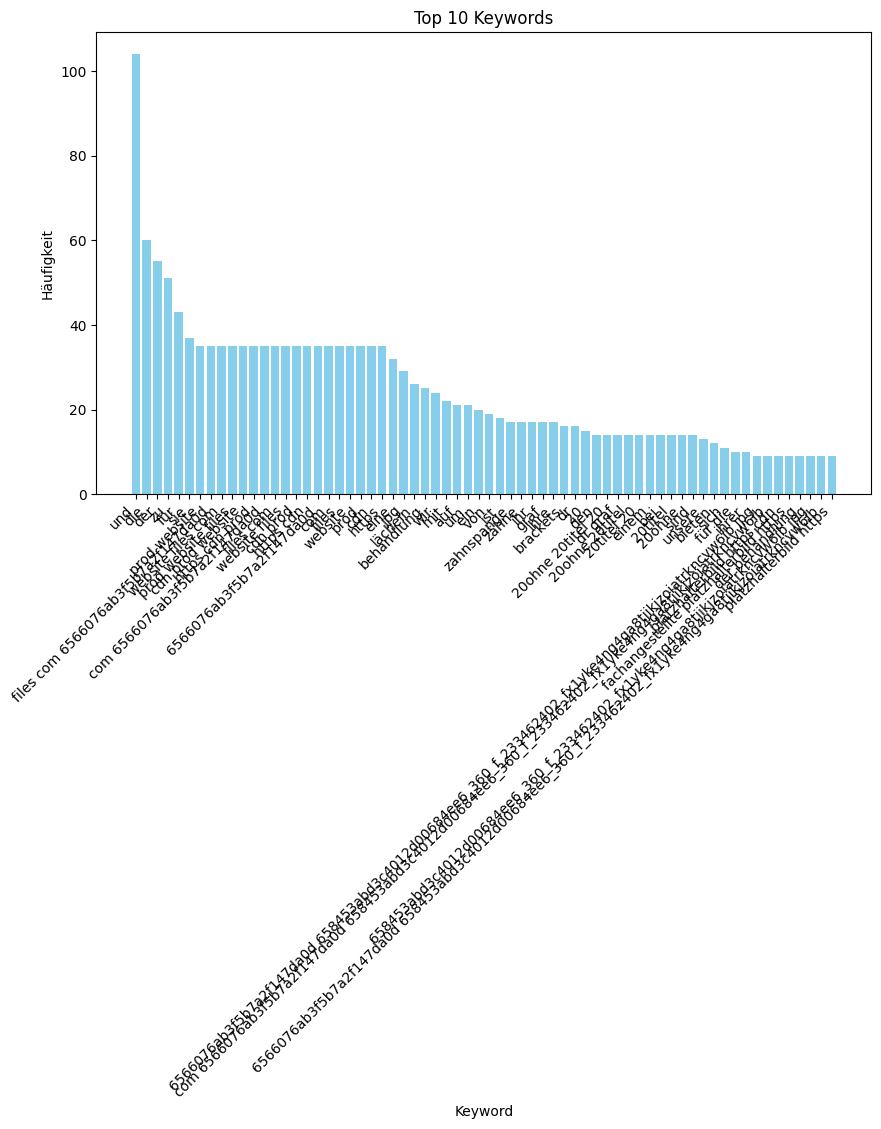

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispiel: Wir holen uns das Keyword-Dictionary
keywords_dict = report.get("keywords", {})

# Wenn es tatsächlich ein dict ist: {"keyword1": count, "keyword2": count, ...}
df_keywords = pd.DataFrame(keywords_dict)

# Sortieren nach Häufigkeit absteigend
df_keywords.sort_values("count", ascending=False, inplace=True)

# Nur die Top 10 Keywords anzeigen
df_top10 = df_keywords.head(66)

# Einfaches Balkendiagramm
plt.figure(figsize=(10, 6))
plt.bar(df_top10['word'], df_top10["count"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Keywords")
plt.xlabel("Keyword")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()


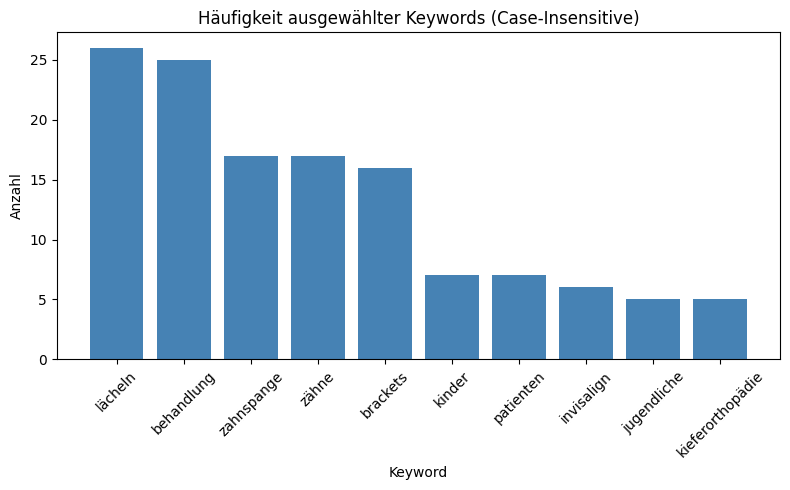

In [46]:
import matplotlib.pyplot as plt


# Beispiel: Wir holen uns das Keyword-Dictionary
keywords_dict = report.get("keywords", {})

# Wenn es tatsächlich ein dict ist: {"keyword1": count, "keyword2": count, ...}
df_keywords = pd.DataFrame(keywords_dict)

# Neue Spalte mit Kleinbuchstaben erzeugen
df_keywords["word_lower"] = df_keywords["word"].str.lower()

# Die Keywords, nach denen du suchen möchtest (Case-insensitive)
interesting_keywords = ["zahnspange", "Invisalign", "kieferorthopädie", "BEHANDLUNG", "Kosten" , "zähne", "brackets", "Unsichtbar", "Kinder", "Jugendliche", "Patienten", "lächeln"]
# Auch diese in Kleinbuchstaben umwandeln
interesting_keywords_lower = [kw.lower() for kw in interesting_keywords]

# DataFrame nach den gewünschten Keywords filtern (Case-insensitive)
df_subset = df_keywords.loc[df_keywords["word_lower"].isin(interesting_keywords_lower)].copy()

# Sortieren nach Häufigkeit, damit das Diagramm übersichtlicher wird
df_subset.sort_values("count", ascending=False, inplace=True)

# Balkendiagramm
plt.figure(figsize=(8, 5))
# Plotten kannst du z.B. weiterhin den Originalwert "word" (falls du im Diagramm
# die ursprüngliche Schreibweise sehen willst)
plt.bar(df_subset["word"], df_subset["count"], color="steelblue")
plt.title("Häufigkeit ausgewählter Keywords (Case-Insensitive)")
plt.xlabel("Keyword")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

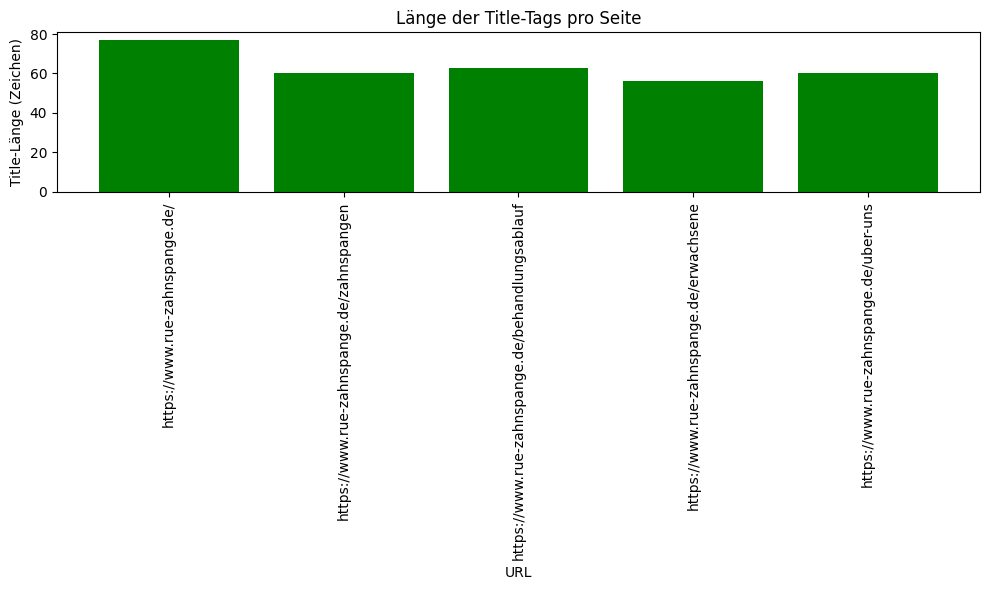

In [47]:
pages = report.get("pages", [])

df_pages = pd.DataFrame(pages)

# Beispiel: Title-Länge berechnen
df_pages["title_length"] = df_pages["title"].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Balkendiagramm Title-Länge
plt.figure(figsize=(10, 6))
plt.bar(df_pages["url"], df_pages["title_length"], color="green")
plt.xticks(rotation=90)
plt.title("Länge der Title-Tags pro Seite")
plt.xlabel("URL")
plt.ylabel("Title-Länge (Zeichen)")
plt.tight_layout()
plt.show()


<ipython-input-48-f71e74ebdef3>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_top10["word"], rotation=45, ha="right")
<ipython-input-48-f71e74ebdef3>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_pages["url"], rotation=90)


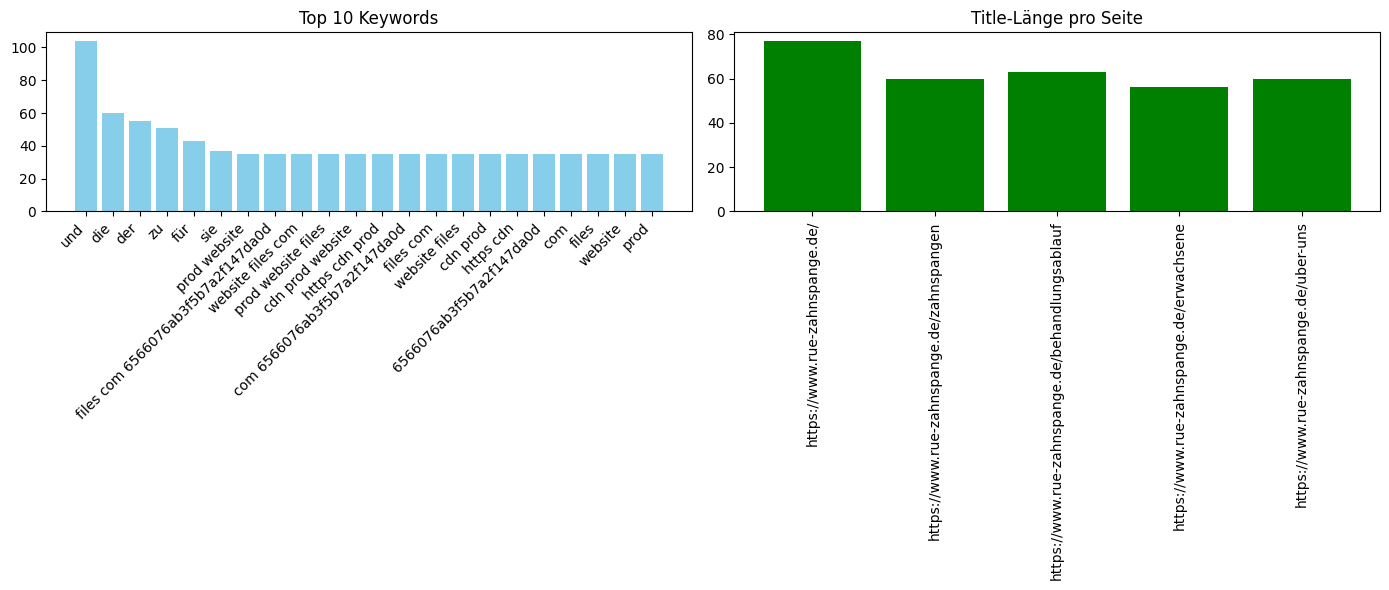

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 Zeile, 2 Spalten

# (a) Keywords
axes[0].bar(df_top10["word"].head(22), df_top10["count"].head(22), color="skyblue")
axes[0].set_title("Top 10 Keywords")
axes[0].set_xticklabels(df_top10["word"], rotation=45, ha="right")

# (b) Title-Längen
axes[1].bar(df_pages["url"], df_pages["title_length"], color="green")
axes[1].set_title("Title-Länge pro Seite")
axes[1].set_xticklabels(df_pages["url"], rotation=90)

plt.tight_layout()
plt.show()


# 🤖 chatbot

In [49]:
import openai
import time
os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_api_key')

class Chatbot:
    """
    Diese Chatbot-Klasse nutzt die neue Methode client.chat.completions.create()
    aus openai>=1.0.0 über openai.OpenAI().
    """

    def __init__(self, systemprompt, prompt):
        self.client = openai.OpenAI(api_key=os.environ['OPENAI_API_KEY'])
        self.systemprompt = systemprompt
        self.prompt = prompt
        self.context = [{"role": "system", "content": systemprompt}]
        self.model = "gpt-4o-mini-2024-07-18"  # Beispiel-Modell

    def chat(self):
        """
        Sendet den Prompt an das Chat-Interface und gibt den kompletten Antwort-String zurück.
        """
        self.context.append({"role": "user", "content": self.prompt})
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=self.context
            )
            response_content = response.choices[0].message.content
            self.context.append({"role": "assistant", "content": response_content})
            return response_content
        except Exception as e:
            print(f"Fehler bei der OpenAI-Anfrage: {e}")
            return ""


    def chat_with_streaming(self):
            """
            Interagiert mit OpenAI Chat Completion API und streamt die Antwort.
            """
            # Nachricht zur Konversation hinzufügen
            self.context.append({"role": "user", "content": self.prompt})

            # print(f"User: {self.prompt}")
            # print("AI: ", end="", flush=True)

            try:
                # Streaming-Option aktivieren
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=self.context,
                    stream=True
                )

                streamed_content = ""  # Zum Speichern der gestreamten Antwort

                for chunk in response:
                    # Debugging: Anzeigen, was tatsächlich in jedem Chunk enthalten ist
                    delta = chunk.choices[0].delta
                    content = getattr(delta, "content", "")

                    if content:  # Verarbeite nur nicht-leere Inhalte
                        print(content, end="", flush=True)
                        streamed_content += content

                print()  # Neue Zeile am Ende

                # Gestreamte Antwort zur Konversation hinzufügen
                self.context.append({"role": "assistant", "content": streamed_content})

                # Return the streamed content
                return streamed_content # This line was added

            except Exception as e:
                print(f"\nDEBUG: An error occurred during streaming: {e}")
                # Return empty string in case of error
                return "" # This line was added


# 🆎 NLP

In [50]:
def chunk_text(text, max_tokens=10000):
    """
    Teilt den Text in Blöcke auf, damit er nicht zu lang
    für die OpenAI-API wird.
    Hier sehr vereinfacht: 1 Token ~ 4 Zeichen.
    """
    chunks = []
    approx_char_limit = max_tokens * 4
    start = 0
    while start < len(text):
        end = start + approx_char_limit
        chunk = text[start:end]
        chunks.append(chunk)
        start = end
    return chunks


# 🚧 main SEO optimize

In [63]:
combined_analysis_list = []
filtered_urls = []

def main():
    # 1. SCRAPING
    start_url = "https://www.rue-zahnspange.de/"
    scraper = WebsiteScraper(start_url=start_url, max_pages=20)
    scraper.scrape_website()

    # Alle gescrapten Daten abrufen
    scraped_data = scraper.get_scraped_data()

    # 2. Sichten der Texte und Filtern
    #    Hier könntest du jetzt z. B. manuell prüfen, welche URLs wichtig sind.
    #    Wir geben einfach mal alle URLs aus:
    print("\n--- Gesammelte Seiten und Inhalte (gekürzt) ---")
    for url, text in scraped_data.items():
        print(f"\nURL: {url}")
        # Beispiel: Nur ersten 200 Zeichen zeigen
        print(f"Text: {text[:200]}...")




    EXCLUDED_KEYWORDS = ["impressum", "datenschutz", "agb"]

    # Alle URLs sammeln, die KEINEN der ausgeschlossenen Begriffe enthalten
    for url in scraped_data.keys():
        # Schauen, ob einer der EXCLUDED_KEYWORDS im URL-String (kleingeschrieben) vorkommt
        if any(keyword in url.lower() for keyword in EXCLUDED_KEYWORDS):
            # Falls ja, überspringen wir diese URL
            continue
        # Sonst nehmen wir sie auf
        filtered_urls.append(url)
        print(f"send text to LLM:  {url}")





    # 3. SEO-Analyse starten (für gefilterte Seiten)
    for url in filtered_urls:
        # Die gesamte Seite analysieren
        page_text = scraped_data[url]

        # 3.1 Chunken, um zu große Anfragen zu vermeiden
        text_chunks = chunk_text(page_text, max_tokens=10000)

        print(f"\n=== Analyzing {url} ===")
        all_analyses = []
        for i, chunk in enumerate(text_chunks):
            print(f" - Sende Chunk {i+1}/{len(text_chunks)} an Chatbot ...")

            # Prompt definieren (SEO)
            system_prompt = "Du bist ein hochqualifizierter SEO-Experte. Du hast Zahnmedizin und Kieferorthopädie studiert und arbeitest für erfolgreiche online marketing experten!"
            user_prompt = ("""
                "1. Untersuche den folgenden Text auf Keyword-Optimierung, Lesbarkeit und mögliche SEO-Verbesserungen. "
                "Wichtige SEO Keywords sind:"
                "Kieferorthopäde / Kieferorthopädin
                Kieferorthopädie
                Zahnspange (allgemein)
                Feste Zahnspange / herausnehmbare Zahnspange
                Invisalign (oder alternative Aligners)
                Zahnregulierung / Zahnkorrektur
                Zahnfehlstellung / Zahnfehlstellungen
                Bisskorrektur
                Kiefergelenksprobleme
                Retainer (Haltespange)"

                Kosten Kieferorthopädie / Zahnspange Kosten
                Kieferorthopädische Behandlung / Ablauf
                Beratung Kieferorthopädie / Erstberatung Kieferorthopäde
                Unsichtbare Zahnspange / Transparente Zahnschienen
                Kieferorthopädie Kinder / Jugendliche
                Kieferorthopädie Erwachsene
                Kieferorthopädische Notfallbehandlung


                longtail keywords:
                „Welche Zahnspange bei schiefen Frontzähnen?“
                „Wie lange dauert eine kieferorthopädische Behandlung bei Erwachsenen?“
                „Was kostet eine durchsichtige Zahnspange?“
                „Unterschied feste Zahnspange vs. Aligner“
                „Kieferorthopäde oder Zahnarzt – wer ist zuständig?“

                Die Praxis liegt in Essen, im Süden in Rüttenscheid. Der Name der Praxis ist 'RÜ Zahnspange'.


                "2. Formuliere den Text entsprechend optimaler SEO Sichtbarkeit um. Der Tonfall soll weiterhin nett und freundlich sein und einen warmen, einfühlsamen Eindruck machen. "
                "Wir wollen die Patientenzahl der Praxis steigern aber die Kommunikation darf nicht aufdringlich wirken. "
                "Es soll trotzdem weiterhin ein hoher medizinisch- fachlicher Standard gehalten werden und Professionalität und Exzellenz soll vermittelt werden!"
                "Die Fragen und Antworten in den FAQs sollen ebenfalls optimiert werden. Es dürfen keine Fragen oder sonstige Textabschnitte weggelassen werden! Wir wollen grundsätzlich den Text nicht substanzielle verändern, "
                "sondern eine bereits bestehende website optimieren. das bedeutet auch, dass die Anzahl der Wörter etwa gleich bleiben sollte, um das bestehende Format der website nicht zu sehr zu beeinflussen."
                "Falls notwendig, füge Meta-Titel und longtail keywords hinzu!"
                "3. Als Ausgabe gebe eine detaillierte, ausführliche und umfassende Analyse des SEO Status des Textes aus, Überschrift: Analyse. Gebe dann deine optimierte Version aus, Überschrift: SEO. Schliesse ab mit detaillierten und ausführlichen Erläuterungen, warum du die Änderungen durchgeführt hast, Überschrift: Erklärung."
                "Die überschriften sind sehr wichtig und müssen über den Abschnitten stehen!"
                "Benutze keine Formatierungszeichen wie ###, # oder **! Mein Job hängt davon ab!"
                """
                "Hier ist der Text chunk: \n\n"
                f"{chunk}"
            )

            # ChatGPT aufrufen
            cb = Chatbot(systemprompt=system_prompt, prompt=user_prompt)
            analysis = cb.chat_with_streaming()
            all_analyses.append(analysis)

            # Warte kurz (Rate Limits, API-Kosten etc.)
            time.sleep(1)

        # 3.2 Fertige Analyse (alle Chunks zusammen)
        combined_analysis = "\n".join(all_analyses)


        combined_analysis_list.append(combined_analysis)
        # print(f"\n--- SEO-Analyse für {url} ---")
        # print(combined_analysis)


if __name__ == "__main__":
    main()



--- Gesammelte Seiten und Inhalte (gekürzt) ---

URL: https://www.rue-zahnspange.de/
Text: RÜ
Moderne Zahnspangen für ein gesünderes Lächeln
Entdecken Sie die Praxis RÜ Zahnspange und unsere vielseitigen Behandlungen für Kinder und Jugendliche, die ein langanhaltendes und gesundes Lächeln e...

URL: https://www.rue-zahnspange.de/zahnspangen
Text: RÜ
Entdecken Sie unsere Zahnspangen
Jede Behandlung erfordert individuelle Zahnspangen verschiedenster Arten. Werfen Sie einen Blick darauf, was wir zu bieten haben.
Feste Zahnspangen
Verlässliche und...

URL: https://www.rue-zahnspange.de/behandlungsablauf
Text: RÜ
Wir begleiten Sie bei jedem Schritt
Entdecken Sie unseren umfassenden Behandlungsablauf, der jeden Schritt zu Ihrem idealen Lächeln sorgfältig begleitet.
Ihr Weg zu einem perfekten Lächeln
Bevor wi...

URL: https://www.rue-zahnspange.de/erwachsene
Text: RÜ
Verwandeln Sie Ihr Lächeln ohne Kompromisse
Entscheiden Sie sich für eines der weltweit beliebtesten Systeme mit transparenten

In [52]:
"Für Kieferorthopäden sind vor allem Keywords mit Ortsbezug („Kieferorthopäde + Stadt“) und behandlungsspezifische Begriffe („Zahnspange“, „Zahnfehlstellung“, „Invisalign“) entscheidend. Zusätzlich sollte man sich auf häufige Fragen (Long-Tail-Keywords) konzentrieren und regelmäßige Fach- und Ratgeber-Artikel veröffentlichen, um auch in der organischen Suche besser gefunden zu werden."

'Für Kieferorthopäden sind vor allem Keywords mit Ortsbezug („Kieferorthopäde + Stadt“) und behandlungsspezifische Begriffe („Zahnspange“, „Zahnfehlstellung“, „Invisalign“) entscheidend. Zusätzlich sollte man sich auf häufige Fragen (Long-Tail-Keywords) konzentrieren und regelmäßige Fach- und Ratgeber-Artikel veröffentlichen, um auch in der organischen Suche besser gefunden zu werden.'

In [73]:
import re
import json

def extract_sections_to_json(texts, keys):
    """Extrahiert Abschnitte aus mehreren Texten und konvertiert sie in JSON."""

    all_sections = []  # Liste für alle Abschnitte

    for text in texts:
        pattern = r"(Analyse|SEO|Erklärung)\n(.*?)(?=\n(?:Analyse|SEO|Erklärung|$))"
        matches = re.findall(pattern, text, re.DOTALL | re.MULTILINE | re.UNICODE)
        sections_dict = {}
        for heading, content in matches:
            sections_dict[heading] = content.strip()
        all_sections.append(sections_dict)  # Abschnitte zur Liste hinzufügen

    # Kombinieren der Abschnitte mit Keys
    final_json_data = {}  # Dictionary für das finale JSON
    for i, sections_dict in enumerate(all_sections):
        key = keys[i]  # Key aus der Liste holen
        final_json_data[key] = sections_dict  # Abschnitte zum Dictionary hinzufügen

    json_data = json.dumps(final_json_data, indent=4, ensure_ascii=False)
    return json_data


keys = filtered_urls  # Keys für die Texte

json_output = extract_sections_to_json(combined_analysis_list, keys)
print(json_output)

{
    "https://www.rue-zahnspange.de/": {
        "Analyse": "Im aktuellen Text gibt es einige Bereiche, die hinsichtlich der Keyword-Optimierung, Lesbarkeit und allgemeinem SEO-Potential verbessert werden könnten. Obwohl die wichtigen Keywords enthalten sind, fehlt es an einer klaren Struktur und Variation in der Verwendung der Keywords. Weiterhin könnte die Lesbarkeit durch kürzere Sätze und prägnantere Absätze verbessert werden. Hier einige spezifische Punkte zur Analyse:",
        "SEO": "**RÜ Zahnspange – Ihr Kieferorthopäde für ein gesundes Lächeln in Essen**",
        "Erklärung": "Die vorgenommenen Änderungen sind das Ergebnis von gezielten Überarbeitungen zur Verbesserung der SEO-Performance und der Lesbarkeit des Textes."
    },
    "https://www.rue-zahnspange.de/zahnspangen": {
        "Analyse": "Der ursprüngliche Text enthält bereits viele wichtige Keywords und einige Long-Tail-Keywords, die für die Kieferorthopädie relevant sind. Dennoch gibt es Optimierungsbedarf bezügli

In [71]:
for text in combined_analysis_list:
  extract_sections_to_json(text)

In [70]:
len(combined_analysis_list)

5

# 📥 RAG

In [53]:
"Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."

"Als in Kenia geborene Kieferorthopädin bringt Dr. Graf eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."

"Die Hauptschwachstellen sind:"

'Die Hauptschwachstellen sind:'

In [54]:
pip install langchain faiss-cpu


In [55]:
pip install -U langchain-community

In [56]:
pip install tiktoken

In [57]:
import os
import openai
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document

# 0) Vector Index (FAISS) initialisieren
#    (Später im Code können wir den Index persistent speichern/neu laden)
# os.environ["OPENAI_API_KEY"] = "DEIN_OPENAI_API_KEY"

embeddings = OpenAIEmbeddings()

# Beispiel-Fehler als "Dokument" für den Vector Store
# "page_content" = Text, "metadata" = beliebige Zusatzinfos
known_error_text = """
Fehler: "Klaren Aligner" wird fälschlicherweise als Eigenname verwendet,
         obwohl es grammatisch richtig "klaren Alignern" sein sollte.

Richtige Anwendung:
- Sagen: "Entdecken Sie die Vorteile von klaren Alignern."
- Oder: "Klare Aligner sind die ..."

Zusätzliche Hinweise:
- Beim Eindeutschen englischer Fachbegriffe auf die Pluralbildung achten.
"""

doc = Document(
    page_content=known_error_text,
    metadata={"error_type": "grammar/de-english", "example_id": "klaren-aligner"}
)

# Vektorindex erzeugen und das "bekannte Fehler"-Dokument ablegen
vector_store = FAISS.from_documents([doc], embeddings)


In [58]:
from langchain.docstore.document import Document

# 1. Neuer Fehler: "Kauen- und Sprechprobleme" statt "Kau- und Sprechprobleme"
doc1_text = """
Fehler: "Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."
Richtig: "Eine Zahnspange kann Kiefergelenksbeschwerden, Kau- und Sprechprobleme effektiv behandeln."

Grund:
- Falsche Rechtschreibung/Zusammensetzung bei "Kauen-".
- Richtig ist "Kau- und Sprechprobleme".
"""

doc1 = Document(
    page_content=doc1_text,
    metadata={
        "error_type": "grammar/spelling",
        "example_id": "kauen-sprechprobleme"
    }
)

# 2. Neuer Fehler: falsche Formulierung bei Sprachen
doc2_text = """
Fehler: "Als in Kenia geborene Kieferorthopädin ... spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."
Richtig: "Als in Kenia geborene Kieferorthopädin ... spricht neben Deutsch auch Englisch und Swahili und verfügt über Grundkenntnisse in Arabisch und Spanisch."

Grund:
- Bessere Formulierung, um 'über Grundkenntnisse' mit 'verfügt über Grundkenntnisse' zu vereinen.
- Straffere und klarere Satzstruktur.
"""

doc2 = Document(
    page_content=doc2_text,
    metadata={
        "error_type": "grammar/style",
        "example_id": "languages-phrase"
    }
)


# Angenommen, du hast bereits:
# embeddings = OpenAIEmbeddings()
# vector_store = FAISS.from_documents([some_initial_docs], embeddings)
#
# -> Dann fügen wir jetzt doc1 und doc2 hinzu:

vector_store.add_documents([doc1, doc2])


['af74996a-f13d-461f-9a7c-7ca6c397e33a',
 '2cf71851-1e55-49af-bdca-f805e9130673']

In [59]:
# faiss_index_path = userdata.get('gdrive_seo_folder') + '/faiss_index'
# vector_store.save_local(faiss_index_path)

In [60]:
# FAISS.load_local(faiss_index_path, embeddings, allow_dangerous_deserialization=True)

In [61]:
def chunk_text_2(text, chunk_size=500):
    """
    Beispiel: einfach alle 500 Zeichen ein Chunk.
    Für echte Token-Logik kann man tiktoken oder langchain-Splitter nutzen.
    """
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end
    return chunks

chunked_texts = []
for seo_text in seo_optimized_texts:
    # Chunking pro SEO-Text
    text_chunks = chunk_text_2(seo_text, chunk_size=500)
    chunked_texts.append(text_chunks)

# chunked_texts = [
#   [chunk1_of_text1, chunk2_of_text1, ...],
#   [chunk1_of_text2, ...],
#   ...
# ]


NameError: name 'seo_optimized_texts' is not defined

In [ ]:
from langchain.text_splitter import TokenTextSplitter

def chunk_text_langchain(text, max_tokens=500, overlap=50):
    """
    Teilt den Text anhand der Tokenanzahl auf. Nutzt dafür LangChain's TokenTextSplitter.
    - max_tokens: maximale Tokens pro Chunk
    - overlap: wie viele Tokens Überschneidung zum vorherigen Chunk
    """
    splitter = TokenTextSplitter(
        encoding_name=OpenAIEmbeddings(),  # oder passend zu deinem Modell (z.B. "gpt-3.5-turbo")
        chunk_size=max_tokens,         # maximale Anzahl Tokens pro Chunk
        chunk_overlap=overlap          # Tokens, die sich mit dem vorigen Chunk überschneiden (Kontext)
    )

    chunks = splitter.split_text(text)
    return chunks

# Beispielanwendung:
# seo_text = """Hier Dein langer Text, den du chunken willst ..."""
# chunked = chunk_text_langchain(seo_text, max_tokens=500, overlap=50)
# print(chunked)



chunked_texts = []
for seo_text in seo_optimized_texts:
    # Chunking pro SEO-Text
    chunked = chunk_text_langchain(seo_text, max_tokens=500, overlap=50)
    chunked_texts.append(text_chunks)


In [ ]:
chunked_texts

In [ ]:
def get_context_from_vector_store(chunk):
    """
    Sucht im FAISS-Index nach passenden Dokumenten zum gegebenen Chunk,
    z. B. bekannte Fehler, die diesem Chunk ähneln.
    """
    # top_k=2 oder so, je nach Bedarf
    results = vector_store.similarity_search(chunk, k=2)
    # results ist eine Liste von Document-Objekten

    # Wir wollen z. B. den Inhalt zusammenfügen als "Kontext":
    context_text = "\n---\n".join([doc.page_content for doc in results])
    return context_text

# Beispielhafte Abfrage pro Chunk
# test_chunk = chunked_texts[0][0]  # Erster Chunk des ersten Textes
# retrieved_context = get_context_from_vector_store(test_chunk)
# print("Kontext aus Vektorindex:\n", retrieved_context)


In [ ]:
import json

def proofread_text_with_context(chunk, context):
    """
    Fragt ChatGPT (mittels der Chatbot-Klasse) an, um den Textchunk auf Fehler zu prüfen und zu korrigieren.
    Nutzt den Kontext aus dem Vector Store, um bekannte Fehler zu berücksichtigen.

    Erwartete Antwortstruktur (JSON):

    {
      "corrected_text": "...",
      "new_mistakes_found": [
        {
          "description": "Beschreibung des neuen Fehlers",
          "original_snippet": "Die fehlerhafte Passage"
        },
        ...
      ]
    }
    """

    # 1. System Prompt
    system_prompt = (
        "Du bist ein professioneller Lektor und Grammatik-Experte. "
        "Du kennst deutsche Grammatik, Rechtschreibung und eingedeutschte Fachbegriffe."
    )

    # 2. User Prompt
    #    Wir kombinieren den Kontext und unseren zu prüfenden Text, plus
    #    die Anweisung, nur JSON auszugeben.
    user_prompt = f"""
Im Folgenden siehst du bereits bekannte Fehlerhinweise (Kontext). Nutze diese Infos,
um den Text zu prüfen und zu korrigieren. Solltest du neue Fehler (Grammatik,
falsch eingedeutschte Worte, Satzstellung etc.) finden, liste sie gesondert auf.

Bekannte Fehler (Kontext):
{context}

Text zur Prüfung:
{chunk}

Anweisung:
1) Analysiere den Text gründlich auf sprachliche/grammatische Fehler.
2) Nutze ggf. den Kontext.
3) Korrigiere diese Fehler im Text, ohne den Sinn zu verändern.
4) Liste alle neu gefundenen Fehler (noch nicht im Kontext) zusätzlich auf.
5) Antworte in folgendem JSON-Format (ohne weitere Worte davor oder danach!):

{{
  "corrected_text": "TEXTVERSION KORRIGIERT",
  "new_mistakes_found": [
    {{
      "description": "Beschreibung des Fehlers",
      "original_snippet": "Snippet der Original-Passage"
    }}
  ]
}}
"""

    # 3. Chatbot verwenden:
    cb = Chatbot(systemprompt=system_prompt, prompt=user_prompt)

    # Da wir keine Streaming-Ausgabe brauchen, nutzen wir hier `chat()` statt `chat_with_streaming()`.
    response_raw = cb.chat()

    # 4. JSON parsen
    try:
        parsed = json.loads(response_raw)
        # parsed = {
        #   "corrected_text": "...",
        #   "new_mistakes_found": [...]
        # }
        return parsed

    except json.JSONDecodeError:
        print("Fehler: ChatGPT hat kein gültiges JSON zurückgegeben.")
        return {
            "corrected_text": "Fehler: Keine gültige JSON-Antwort.",
            "new_mistakes_found": []
        }


In [ ]:
all_corrected_texts = []
all_new_mistakes = []

for text_chunks in chunked_texts:  # => Jede Liste von Chunks (pro SEO-Text)
    corrected_text_chunks = []

    for chunk in text_chunks:
        # 3a) Kontext abfragen
        context = get_context_from_vector_store(chunk)


        # 4a) Prompt ChatGPT (Korrektur)
        result = proofread_text_with_context(chunk, context)

        corrected_text = result["corrected_text"]
        new_mistakes = result["new_mistakes_found"]

        # Sammeln
        corrected_text_chunks.append(corrected_text)
        all_new_mistakes.extend(new_mistakes)

    # Pro SEO-Text fügen wir die korrigierten Chunks zusammen.
    full_corrected_text = "\n".join(corrected_text_chunks)
    all_corrected_texts.append(full_corrected_text)

# Jetzt haben wir:
# all_corrected_texts = [ "korrigierter SEO Text Nr.1", "korrigierter SEO Text Nr.2", ...]
# all_new_mistakes = Liste aller neu gefundenen Fehler


In [ ]:
for _ in all_corrected_texts:
  print(_)

In [ ]:
all_new_mistakes